Estimate the capture rate of molecules partitioning into a nanopore.

    :Created:    12/27/2015
    :Author:     Arvind Balijepalli <arvind.balijepalli@nist.gov>
    :License:    See LICENSE.TXT
    :ChangeLog:
        12/27/15        AB    Initial version

In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from mosaicscripts.analysis.kinetics import CaptureRate, query1Col
import mosaicscripts.plots.mplformat as mplformat
from mosaic.utilities.fit_funcs import singleExponential

In [3]:
mplformat.update_rcParams()

Wrapper Function to Estimate the Capture Rate
-------------

The capture rate can be estimated directly by calling the `CaptureRate` function in `mosaicscripts.analysis.kinetics`. The function returns a list with two elements: the capture rate (s$^{-1}$), and the standard error of the capture rate (s$^{-1}$).

In [4]:
np.round(
        CaptureRate(
            "../data/eventMD-P28-bin.sqlite",
            "select AbsEventStart from metadata where ProcessingStatus='normal' and ResTime > 0.02 order by AbsEventStart ASC"
           ),
        decimals=1
    )

array([ 27.9,   0.2])

The Gory Details
-------------

Continue reading to dig deeper into how the capture rate is estimated within the `CaptureRate` function.

The first step is to read in the start times for each event. This is easily done with a query to the MOSAIC database as shown below. The start times are stored in the `AbsEventStart` column. We limit the events we use to estimate the capture rate to ones that were successfully fit (`ProcessingStatus`='normal') and those whose residence times (`ResTime`) in the pore are longer than 20 $\mu$s.

Finally, we sort the `AbsEventStart` to ensure the event start times are in ascending order.

In [5]:
start_times=query1Col(
        "../data/eventMD-P28-bin.sqlite",
        "select AbsEventStart from metadata where ProcessingStatus='normal' and ResTime > 0.02 order by AbsEventStart ASC"
    )

Next, we calculate the arrival times, i.e. the time between the start of successive events. This is done with the `Numpy` diff function. Note that `AbsEventStart` is stored in seconds within the database. We convert the arrival times to milliseconds to make the formatting a little cleaner.

In [6]:
arrival_times=np.diff(start_times)/1000.

The partitioning of molecules into the pore is a stochastic process. There are however a couple properties related to  stochastic process that we will leverage that makes the estimation of the capture rate more robust. With randomly occuring events that have some mean rate, the number of events scales linearly with time. Therefore, the distribution of these events follows a single exponential form. We can easily test this by calculating the probability density function (PDF) using the `Numpy` histogram function. Note that the `density`=`True` argument normalizes the histogram resulting in a PDF. 

In [7]:
density,bins=np.histogram(arrival_times, bins=100, density=True)

Plot the resulting PDF with `Matplotlib` to verify the distribution. Sure enough on a semilog scale, the resulting distribution appears linear suggesting an exponential form. 

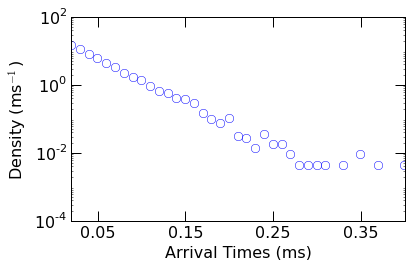

In [17]:
plt.semilogy(
        bins[:len(density)], density, 
        linestyle='None',
        marker='o', 
        markersize=8,
        markeredgecolor='blue',
        markerfacecolor='None'
    )
plt.xlim(0.02,0.4)
plt.xticks([0.05,0.15,0.25,0.35])
plt.yticks([1e-4,1e-2,1,1e2])
plt.axes().set_xlabel("Arrival Times (ms)")
plt.axes().set_ylabel("Density (ms$^{-1}$)")
plt.show()

Next we fit the PDF to a single exponential function of the form $a\ e^{-t/\tau}$, where a is a scaling factor and $\tau$ is the mean time of the distribution (with a rate of 1/$\tau$). This is accomplished with the `curve_fit` function within `Scipy`.

In [10]:
popt, pcov = curve_fit(singleExponential, bins[:len(density)], density, p0=[1, np.mean(arrival_times)])

We then visually check the fit, by superimposing the resulting fit function over the PDF.

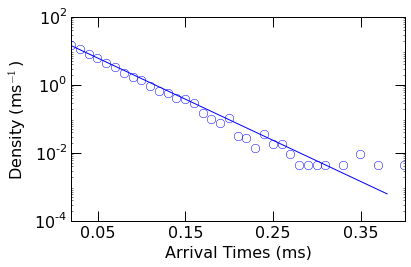

In [15]:
plt.semilogy(
        bins[:len(density)], density, 
        linestyle='None',
        marker='o', 
        markersize=8,
        markeredgecolor='blue',
        markerfacecolor='None'
    )
plt.semilogy( 
            np.arange(0.02,0.4,0.02),
            singleExponential(np.arange(0.02,0.4,0.02), popt[0],popt[1]),
            color='blue'
        )
plt.xlim(0.02,0.4)
plt.xticks([0.05,0.15,0.25,0.35])
plt.yticks([1e-4,1e-2,1,1e2])
plt.axes().set_xlabel("Arrival Times (ms)")
plt.axes().set_ylabel("Density (ms$^{-1}$)")
plt.show()

Finally, we can extract the capture rate (1/$\tau$) from the optimal fit parameters.

In [12]:
np.round([1/popt[1]], decimals=1 )

array([ 27.9])